In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os
import arviz as az

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef

In [4]:
# first, load samples from each run

# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '2'

# sim name
sim_name = 'canon_g1_pnfw'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 0
blg_id = -1
mod_id = 0
svi_id = 1

# variable inputs
sim_seeds = np.arange(4)
svi_seeds = np.arange(0,1)

In [5]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
## NOTE: This information should already be taken into account once
## specifying the relevant IDs ; however, this is a good way to double-check
## you're loading what you want
ebin = 10

temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [6]:
sim_seed = 1
svi_seed = 0

fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))

/
    settings_7p1234567_5p23457_0_-1_0_1_1_0.py
    summary.txt
    __init__.py
    ebin10_smp_svi_0.01_5000_mvn_16_1_0.p


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
print(jnp.exp(gp_samples).sum(axis = 1))

NameError: name 'gp_samples' is not defined

In [8]:
# TODO: Probably a better way to collect this data; 
# for example, make a dictionary whose inputs are ordered pairs of the variable inputs

samples_svi_sim = []
svi_results_svi_sim = []
# gp_samples_svi_sim = []

for svi_seed in tqdm(svi_seeds, desc = 'svi_seeds'):
    samples_sim = []
    svi_results_sim = []
   #  gp_samples_sim = []
    for sim_seed in tqdm(sim_seeds, desc = 'sim_seeds'):
        # if fit_dir in sys.path:
        #     sys.path.pop(-1)
        fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
        fit_dir = data_dir + 'fits/' + fit_filename + '/'

        sys.path.append(fit_dir)
        import importlib 
        module = importlib.import_module(module_name)

        # Load all the variables from the module
        globals().update(vars(module))

        file_name = ('ebin' + str_ebin + '_smp_svi_' + 
                     str_lr + '_' + str_n_steps + '_' + 
                        str_guide + '_' + str_num_particles + '_' + 
                        str_sim_seed + '_' + str_svi_seed + '.p')

        if is_gp:
           samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
        else:
           samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))
        
        samples_sim.append(samples)
        svi_results_sim.append(svi_results)
      #   gp_samples_sim.append(gp_samples)
        
    samples_svi_sim.append(samples_sim)
    svi_results_svi_sim.append(svi_results_sim)
   #  gp_samples_svi_sim.append(gp_samples_sim)

svi_seeds: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


In [9]:
from models.poissonian_ed import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # all parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg= is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        )
ebinmodel.config_model(ebin=ebin)

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_0_-1_0_1_3_0 not in sys.modules
]
[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    m

In [10]:
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

temp_sample_dict_svi_sim = []

# NOTE: Indices now don't track the IDs. So, you need to keep track of the indices
Ncs = len(svi_seeds)
Ncr = len(sim_seeds)
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    temp_sample_dict_sim = []
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        samples = samples_svi_sim[ns][nr]
        # gp_samples = gp_samples_svi_sim[ns][nr]
        temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = None, custom_num=1000, nfw_gamma=nfw_gamma)
        temp_sample_dict_sim.append(temp_sample_dict)
    temp_sample_dict_svi_sim.append(temp_sample_dict_sim)

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

iso
psc
bub
pib




























100%|██████████| 1000/1000 [00:02<00:00, 347.62it/s]


ics





























100%|██████████| 1000/1000 [00:02<00:00, 355.89it/s]


iso
psc
bub
pib
































100%|██████████| 1000/1000 [00:03<00:00, 325.37it/s]


ics






























100%|██████████| 1000/1000 [00:02<00:00, 346.29it/s]


iso
psc
bub
pib




























100%|██████████| 1000/1000 [00:02<00:00, 375.43it/s]


ics




























100%|██████████| 1000/1000 [00:02<00:00, 373.72it/s]


iso
psc
bub
pib





























100%|██████████| 1000/1000 [00:02<00:00, 360.10it/s]


ics



























svi_seeds: 100%|██████████| 1/1 [00:23<00:00, 23.64s/it]


svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

svi_seeds: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


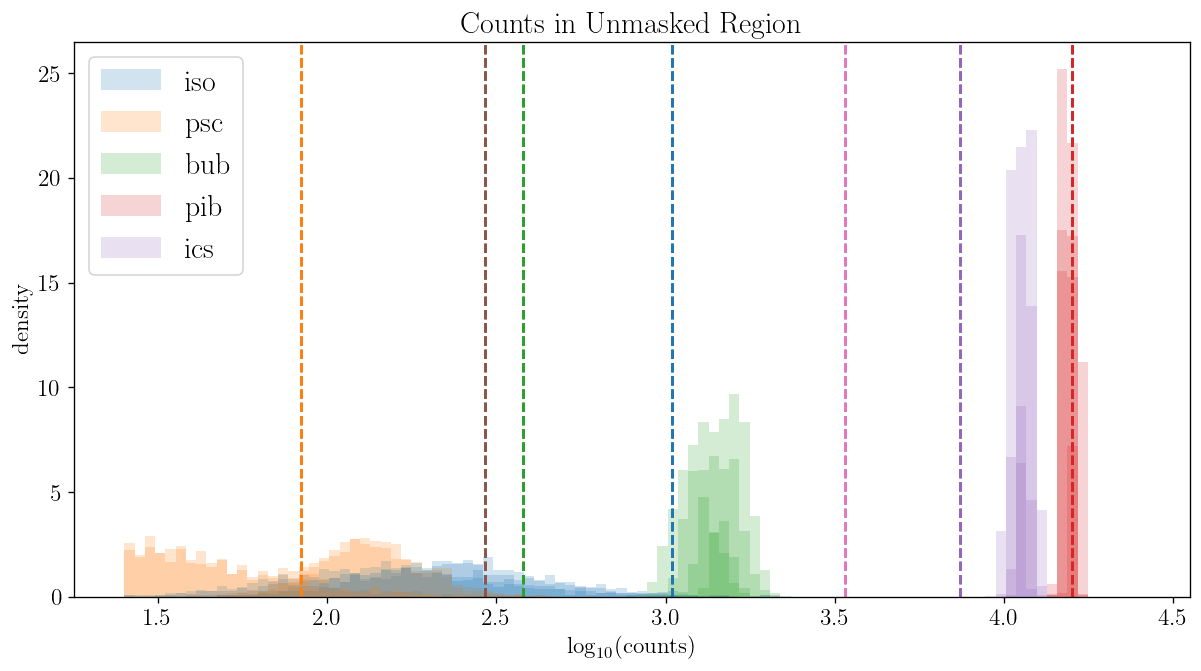

In [12]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

bins = np.linspace(1.4,4.4,100)
alpha = 0.2
histtype = 'stepfilled'

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())
ordered_names = [name for name in all_temp_names if name in names]

Ncs = len(svi_seeds)
Ncr = len(sim_seeds)
c = 0
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        temp_sample_dict = temp_sample_dict_svi_sim[ns][nr]
        for k in range(len(ordered_names)):
            name = ordered_names[k]
            idx = all_temp_names.index(name)
            ccode = ccodes[idx]
            # if name == 'gp':
            #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
            #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
            # else:
            temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
            if c == 0:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, label = name, density = True, histtype = histtype, color = ccode)
            else:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, density = True, histtype = histtype, color = ccode)

        if temp_dict is not None:
            names_sim = temp_names_sim # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
            ordered_names_sim = [name for name in all_temp_names if name in names_sim]
            for k in range(len(ordered_names_sim)):
                name = ordered_names_sim[k]
                idx = all_temp_names.index(name)
                ccode = ccodes[idx]
                temp_sum_sim = temp_dict[name].sum(axis = 0)
                ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
        c += 1
        
        ax.legend()
        ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
        ax.set_ylabel(r'$\mathrm{density}$')
        ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')

In [33]:
sum_gp_samples_svi_sim = []
for ns in tqdm(svi_seeds, desc = 'svi_seeds'):
    sum_gp_samples_sim = []
    for nr in tqdm(sim_seeds, desc = 'sim_seeds'):
        sum_gp_samples_sim.append(jnp.exp(gp_samples_svi_sim[ns][nr]).sum(axis = 1))
    sum_gp_samples_svi_sim.append(sum_gp_samples_sim)

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'gp_samples_svi_sim' is not defined

In [21]:
print(sum_gp_samples_svi_sim[0][0])

[37042.05  37394.523 36659.703 38262.113 37035.773 37522.824 38295.477
 37263.68  38953.207 37943.04  37436.43  35760.25  36461.402 37481.547
 37672.688 38627.312 35932.184 37379.49  38358.156 37228.977 36521.36
 39143.023 35737.336 38266.53  40100.926 37638.33  39345.18  37033.266
 37264.73  38079.71  35979.848 38451.82  38181.375 38166.39  34754.453
 36961.223 36271.457 38367.47  36850.75  38101.535 37883.406 37809.188
 39575.64  38815.45  39067.29  37562.32  37466.45  40104.84  40450.074
 37490.367 36342.645 36927.914 37296.613 37075.04  39188.28  36392.117
 37137.145 37232.56  38935.055 36628.168 39618.727 38413.484 37312.32
 37615.406 40046.17  37379.24  36758.58  38681.367 37576.984 38204.18
 38954.71  37975.047 37142.43  39127.938 37206.14  36437.59  38267.867
 37713.668 37919.703 36482.656 39787.906 37748.613 37926.07  37941.984
 38979.96  34722.805 37177.715 36699.47  35963.695 37680.04  37913.
 38438.16  40228.715 36004.617 36158.83  40558.566 40506.125 38990.414
 35132.164 3

In [22]:
for ns in tqdm(svi_seeds, desc = 'svi_seeds'):
    for nr in tqdm(sim_seeds, desc = 'sim_seeds'):
        if np.isnan(sum_gp_samples_svi_sim[ns][nr][0]):
            print(ns, nr)

sim_seeds: 100%|██████████| 10/10 [00:00<00:00, 1368.41it/s]


sim_seeds: 100%|██████████| 10/10 [00:00<00:00, 1098.76it/s]

svi_seeds: 100%|██████████| 10/10 [00:00<00:00, 88.24it/s]


svi_seeds: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Text(0, 0.5, '$\\mathrm{Density}$')

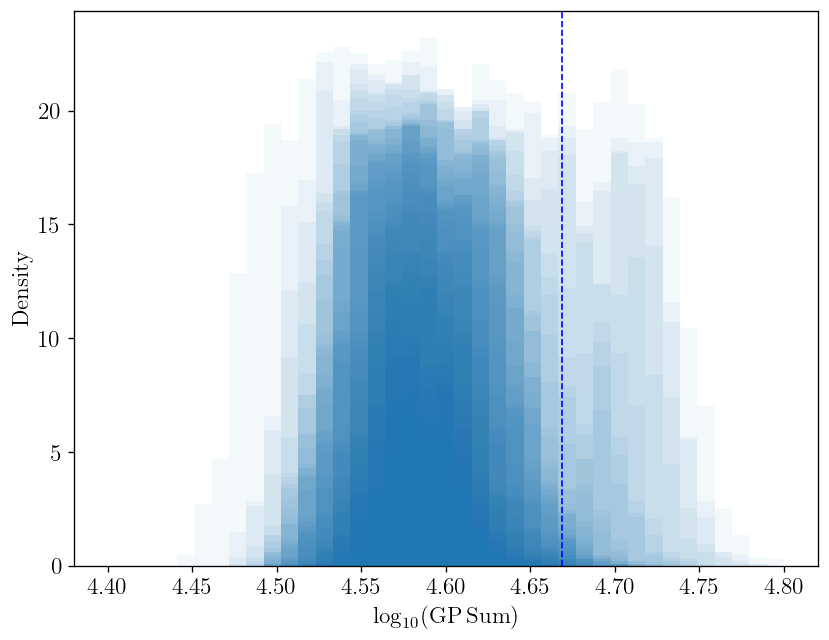

In [23]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
for ns in tqdm(svi_seeds, desc = 'svi_seeds'):
    for nr in tqdm(sim_seeds, desc = 'sim_seeds'):
        if np.isnan(sum_gp_samples_svi_sim[ns][nr][0]):
            continue
        else:
            ax.hist(jnp.log10(sum_gp_samples_svi_sim[ns][nr]), np.linspace(4.4,4.8,40), alpha = 0.05, color = 'C0', density = True)
ax.axvline(jnp.log10(temp_dict['blg'].sum()), lw = 1, c = 'b', ls = '--')
ax.set_xlabel(r'$\log_{10}(\mathrm{GP\,Sum})$')
ax.set_ylabel(r'$\mathrm{Density}$')

svi_seeds: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Text(0, 0.5, '$\\mathrm{Density}$')

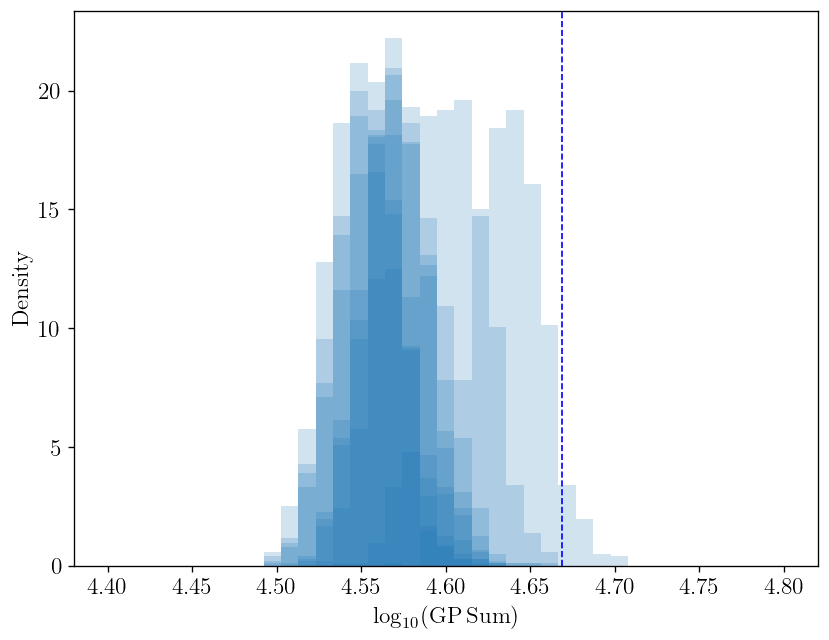

In [18]:
c_sim_seeds = np.arange(10)
c_svi_seeds = [5]

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
for ns in tqdm(c_svi_seeds, desc = 'svi_seeds'):
    for nr in tqdm(c_sim_seeds, desc = 'sim_seeds'):
        if np.isnan(sum_gp_samples_svi_sim[ns][nr][0]):
            continue
        else:
            ax.hist(jnp.log10(sum_gp_samples_svi_sim[ns][nr]), np.linspace(4.4,4.8,40), alpha = 0.2, color = 'C0', density = True)
ax.axvline(jnp.log10(temp_dict['blg'].sum()), lw = 1, c = 'b', ls = '--')
ax.set_xlabel(r'$\log_{10}(\mathrm{GP\,Sum})$')
ax.set_ylabel(r'$\mathrm{Density}$')

In [24]:
from models.poissonian_ed_100 import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # all parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg= is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        )
ebinmodel.config_model(ebin=ebin)

In [41]:
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

temp_sample_dict_svi_sim = []

# NOTE: Indices now don't track the IDs. So, you need to keep track of the indices
Ncs = len(c_svi_seeds)
Ncr = len(c_sim_seeds)
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    temp_sample_dict_sim = []
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        samples = samples_svi_sim[ns][nr]
        gp_samples = gp_samples_svi_sim[ns][nr]
        temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)
        temp_sample_dict_sim.append(temp_sample_dict)
    temp_sample_dict_svi_sim.append(temp_sample_dict_sim)

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 842.43it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 850.50it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 889.03it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 865.08it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 849.55it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 920.20it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 850.49it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 884.56it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 838.37it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 842.18it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 847.17it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 849.10it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 944.89it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 955.88it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 956.90it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 953.39it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 914.16it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 929.60it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 929.66it/s]


ics























svi_seeds: 100%|██████████| 1/1 [00:25<00:00, 25.23s/it]


svi_seeds: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


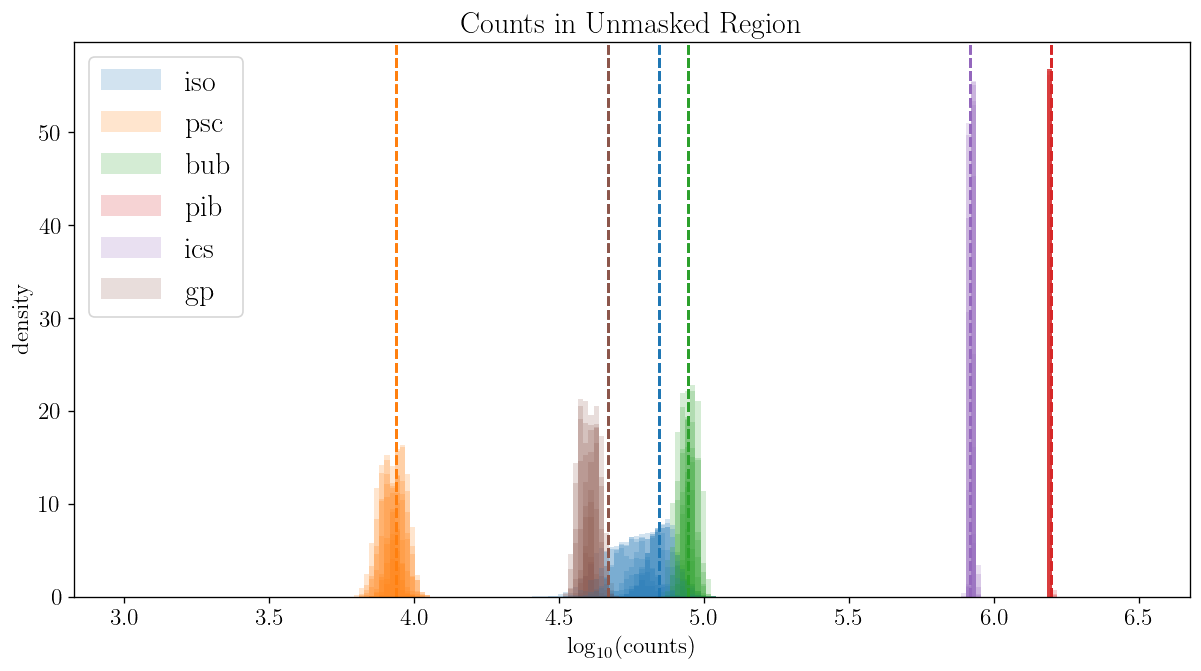

In [48]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

bins = np.linspace(3,6.5,200)
alpha = 0.2
histtype = 'stepfilled'

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())
ordered_names = [name for name in all_temp_names if name in names]

Ncs = len(c_svi_seeds)
Ncr = len(c_sim_seeds)
c = 0
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        temp_sample_dict = temp_sample_dict_svi_sim[ns][nr]
        for k in range(len(ordered_names)):
            name = ordered_names[k]
            idx = all_temp_names.index(name)
            ccode = ccodes[idx]
            # if name == 'gp':
            #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
            #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
            # else:
            temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
            if c == 0:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, label = name, density = True, histtype = histtype, color = ccode)
            else:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, density = True, histtype = histtype, color = ccode)

        if temp_dict is not None:
            names_sim = temp_names_sim # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
            ordered_names_sim = [name for name in all_temp_names if name in names_sim]
            for k in range(len(ordered_names_sim)):
                name = ordered_names_sim[k]
                idx = all_temp_names.index(name)
                ccode = ccodes[idx]
                temp_sum_sim = temp_dict[name].sum(axis = 0)
                ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
        c += 1
        
        ax.legend()
        ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
        ax.set_ylabel(r'$\mathrm{density}$')
        ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())

ordered_names = [name for name in all_temp_names if name in names]
for k in range(len(ordered_names)):
    name = ordered_names[k]
    idx = all_temp_names.index(name)
    ccode = ccodes[idx]
    # if name == 'gp':
    #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
    #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
    # else:
    temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
    ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)

if temp_sim_dict is not None:
    names_sim = temp_sim_names # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
    ordered_names_sim = [name for name in all_temp_names if name in names_sim]
    for k in range(len(ordered_names_sim)):
        name = ordered_names_sim[k]
        idx = all_temp_names.index(name)
        ccode = ccodes[idx]
        temp_sum_sim = temp_sim_dict[name].sum(axis = 0)
        ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)

ax.legend()
ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
ax.set_ylabel(r'$\mathrm{density}$')
ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')